In [2]:
import numpy as np
import torch
import sys
import matplotlib.pyplot as plt

sys.path.append("../../")
sys.path.append("../")
import NMC as models
import importlib
import os
import glob
import pandas as pd
import scipy.sparse as sp
import anndata as ad
from src import util
from tqdm import tqdm
from torchdiffeq import odeint
import torch.nn as nn
import torch.nn.functional as F

In [3]:
class DataLoader:
    def __init__(self, data_path, dataset_type="Synthetic"):
        """
        Initialize DataLoader

        Args:
            data_path: Path to data directory
            dataset_type: Either "Synthetic" or "Curated"
        """
        self.data_path = os.path.join(data_path, dataset_type)
        self.dataset_type = dataset_type
        self.adatas = None
        self.kos = None
        self.true_matrix = None

    def load_data(self):
        """Load and preprocess data"""
        if self.dataset_type == "Synthetic":
            paths = glob.glob(
                os.path.join(self.data_path, "dyn-TF/dyn-TF*-1")
            ) + glob.glob(os.path.join(self.data_path, "dyn-TF_ko*/dyn-TF*-1"))
        elif self.dataset_type == "Curated":
            paths = glob.glob(os.path.join(self.data_path, f"HSC*/HSC*-1"))
        else:
            raise ValueError(f"Unknown dataset type: {self.dataset_type}")

        self.adatas = [util.load_adata(p) for p in paths]

        df = pd.read_csv(os.path.join(os.path.dirname(paths[0]), "refNetwork.csv"))

        n_genes = self.adatas[0].n_vars

        # Create empty matrix with gene names
        self.true_matrix = pd.DataFrame(
            np.zeros((n_genes, n_genes), int),
            index=self.adatas[0].var.index,
            columns=self.adatas[0].var.index,
        )

        # Fill matrix with interaction values
        for i in range(df.shape[0]):
            _i = df.iloc[i, 1]  # target gene
            _j = df.iloc[i, 0]  # source gene
            _v = {"+": 1, "-": -1}[df.iloc[i, 2]]  # interaction type
            self.true_matrix.loc[_i, _j] = _v

        # Bin timepoints
        t_bins = np.linspace(0, 1, T + 1)[:-1]
        for adata in self.adatas:
            adata.obs["t"] = np.digitize(adata.obs.t_sim, t_bins) - 1

        # Get knockouts
        self.kos = []
        for p in paths:
            try:
                self.kos.append(os.path.basename(p).split("_ko_")[1].split("-")[0])
            except:
                self.kos.append(None)

        self.gene_to_index = {
            gene: idx for idx, gene in enumerate(self.adatas[0].var.index)
        }
        self.ko_indices = []
        for ko in self.kos:
            if ko is None:
                self.ko_indices.append(None)
            else:
                self.ko_indices.append(self.gene_to_index[ko])

In [4]:
T = 5
data_loader = DataLoader("../../data/simulation", dataset_type="Synthetic")
data_loader.load_data()
adatas, kos, ko_indices, true_matrix = (
    data_loader.adatas,
    data_loader.kos,
    data_loader.ko_indices,
    data_loader.true_matrix.values,
)

In [22]:
from sklearn.preprocessing import StandardScaler

def prepare_time_binned_data(adata, time_column='t'):
    """
    Groups cells by their time bins and returns a list of tensors.
    
    Args:
        adata (AnnData): The AnnData object containing cell data.
        time_column (str): The column in adata.obs indicating time bins.
        
    Returns:
        List[torch.Tensor]: A list where each element is a tensor of cells at a specific time bin.
    """
    num_time_bins = adata.obs[time_column].nunique()
    time_bins = sorted(adata.obs[time_column].unique())
    grouped_data = []
    for t in time_bins:
        cells_t = adata[adata.obs[time_column] == t].X
        if isinstance(cells_t, sp.spmatrix):
            cells_t = cells_t.toarray()
        grouped_data.append(torch.from_numpy(cells_t).float())
    return grouped_data

def normalize_data(grouped_data):
    """
    Applies Z-score normalization to each gene across all cells.
    
    Args:
        grouped_data (List[torch.Tensor]): List of tensors grouped by time bins.
        
    Returns:
        List[torch.Tensor]: Normalized data.
    """
    # Concatenate all cells to compute mean and std
    all_cells = torch.cat(grouped_data, dim=0)
    scaler = StandardScaler()
    all_cells_np = all_cells.numpy()
    scaler.fit(all_cells_np)
    
    # Apply normalization
    normalized_data = []
    for tensor in grouped_data:
        normalized = torch.from_numpy(scaler.transform(tensor.numpy())).float()
        normalized_data.append(normalized)
    return normalized_data, scaler

In [23]:
grouped_data = prepare_time_binned_data(adatas[0], time_column='t')
normalized_data, scaler = normalize_data(grouped_data)

In [27]:
normalized_data[1].shape

torch.Size([186, 8])

In [34]:
def train_sequential_discrete_time_ode(
    func,
    normalized_data,
    n_steps_per_transition=2500,
    plot_freq=1000,
    l1_reg=0.0,
    l2_reg=0.05,
    plot=True,
    device="cpu"
):
    """
    Train Neural ODE on discrete, sequentially binned time points.

    Args:
        func (nn.Module): The neural ODE function (e.g., MLPODEF instance).
        normalized_data (List[torch.Tensor]): List of tensors grouped by time bins.
        n_steps_per_transition (int): Number of training steps per transition.
        plot_freq (int): Frequency of plotting results.
        l1_reg (float): L1 regularization strength.
        l2_reg (float): L2 regularization strength.
        plot (bool): Whether to plot during training.
        device (str or torch.device): Device to run training on.
    """
    horizon = 1  # Each transition is ti -> ti+1
    batch_time = horizon
    num_time_bins = len(normalized_data)
    num_transitions = num_time_bins - 1
    num_variables = normalized_data[0].shape[1]
    
    # Define time span for ODE integration (0 to 1)
    transition_times = torch.tensor([0.0, 1.0]).to(device)  # [2]

    def create_batch_for_transition(t_start, batch_size):
        """
        Create a batch for a specific transition from ti to ti+1.

        Args:
            t_start (int): Starting time bin index.
            batch_size (int): Number of samples in the batch.

        Returns:
            Tuple: (x0, t, x1)
                - x0: Initial states at ti, shape [batch_size, num_variables]
                - t: Time tensor, shape [2]
                - x1: Target states at ti+1, shape [batch_size, num_variables]
        """
        # Sample batch_size cells from ti and ti+1
        cells_t0 = normalized_data[t_start]
        cells_t1 = normalized_data[t_start + horizon]
        
        # Handle cases where there are fewer cells than batch_size
        if cells_t0.shape[0] < batch_size:
            indices_t0 = torch.randint(0, cells_t0.shape[0], (batch_size,))
        else:
            indices_t0 = torch.randint(0, cells_t0.shape[0], (batch_size,))
        if cells_t1.shape[0] < batch_size:
            indices_t1 = torch.randint(0, cells_t1.shape[0], (batch_size,))
        else:
            indices_t1 = torch.randint(0, cells_t1.shape[0], (batch_size,))
        
        x0 = cells_t0[indices_t0].to(device)  # [batch_size, num_variables]
        x1 = cells_t1[indices_t1].to(device)  # [batch_size, num_variables]
        
        return x0, transition_times, x1

    def proximal(w, lam=0.1, eta=0.1):
        """Proximal step for group-lasso regularization."""
        # w shape [j * m1, i]
        wadj = w.view(func.dims[0], -1, func.dims[0])  # [d, hidden, d]
        tmp = torch.sum(wadj**2, dim=1).pow(0.5) - lam * eta
        alpha = torch.clamp(tmp, min=0)
        v = F.normalize(wadj, dim=1) * alpha[:, None, :]
        w.data = v.view(-1, func.dims[0])

    # Initialize optimizer
    lr = 0.005
    optimizer = torch.optim.Adam(func.parameters(), lr=lr)

    # Learning rate scheduler (optional)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

    # Total training steps
    total_steps = n_steps_per_transition * num_transitions

    for step in tqdm(range(1, total_steps + 1)):
        # Determine current transition
        transition_idx = (step - 1) // n_steps_per_transition  # 0 to num_transitions-1

        # Current transition time bin
        t_start = transition_idx

        # Create a batch for the current transition
        batch_size = 20  # Adjust based on your computational resources
        x0, t, x1 = create_batch_for_transition(t_start, batch_size)
        x0 = x0.unsqueeze(1)

        # Forward pass through ODE
        z0 = x0  # Initial state at t=0
        z_pred = odeint(func, z0, t)  # Shape: [2, batch_size, num_variables]
        z_pred = z_pred[-1]  # Predicted state at t=1, shape: [batch_size, num_variables]

        # Compute loss (MSE between predicted and true x1)
        loss = F.mse_loss(z_pred, x1)

        # Add regularization
        if l2_reg != 0:
            l2 = func.l2_reg()
            loss += l2_reg * l2
        if l1_reg != 0:
            l1 = func.fc1_reg()
            loss += l1_reg * l1

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Apply proximal operator to fc1.weight
        proximal(func.fc1.weight, lam=func.GL_reg, eta=0.01)

        # Update learning rate scheduler
        scheduler.step()

        # Logging and plotting
        if plot and step % plot_freq == 0:
            with torch.no_grad():
                # Select a sample trajectory and plot
                sample_traj_idx = 0  # Change as needed
                sample_t_start = t_start  # Current transition
                if sample_traj_idx >= normalized_data[sample_t_start].shape[0]:
                    sample_traj_idx = sample_traj_idx % normalized_data[sample_t_start].shape[0]
                sample_x0 = normalized_data[sample_t_start][sample_traj_idx].unsqueeze(0).cpu().numpy()
                sample_x1 = normalized_data[sample_t_start + horizon][sample_traj_idx].unsqueeze(0).cpu().numpy()
                sample_z_pred = odeint(func, normalized_data[sample_t_start][sample_traj_idx].unsqueeze(0).to(device), transition_times).cpu().numpy()
                sample_z_pred = sample_z_pred[-1]  # [1, num_variables]

                # Causal graph extraction
                graph = func.causal_graph(w_threshold=0.0)

                # Plotting
                fig, axs = plt.subplots(1, 3, figsize=(18, 5))
                fig.tight_layout(pad=5.0)

                # Plot original trajectory across all time points
                traj_data = [normalized_data[t][sample_traj_idx % normalized_data[t].shape[0]].cpu().numpy() for t in range(num_time_bins)]
                axs[0].plot(range(num_time_bins), traj_data, label='True Trajectory', marker='o')
                axs[0].set_xlabel('Time Bins')
                axs[0].set_ylabel('Normalized Expression')
                axs[0].set_title('True Trajectory')
                axs[0].legend()

                # Plot predicted vs true at current transition
                axs[1].plot([t_start, t_start + horizon], [sample_x0.flatten(), sample_z_pred.flatten()], marker='o', label='Predicted')
                axs[1].plot([t_start, t_start + horizon], [sample_x0.flatten(), sample_x1.flatten()], marker='x', label='True')
                axs[1].set_xlabel('Time Bins')
                axs[1].set_ylabel('Normalized Expression')
                axs[1].set_title(f'Iteration {step}: Loss={loss.item():.4f}')
                axs[1].legend()

                # Plot causal graph
                im = axs[2].matshow(graph, cmap='viridis')
                axs[2].set_title('Causal Graph')
                fig.colorbar(im, ax=axs[2])

                plt.show()

                # Clear output if running in a notebook
                # Uncomment the following lines if using Jupyter Notebook
                # from IPython.display import clear_output
                # clear_output(wait=True)

  0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_3191198/2172287399.py:103: UserWarning: Using a target size (torch.Size([20, 8])) that is different to the input size (torch.Size([20, 1, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(z_pred, x1)
 10%|▉         | 999/10000 [01:10<07:58, 18.82it/s]

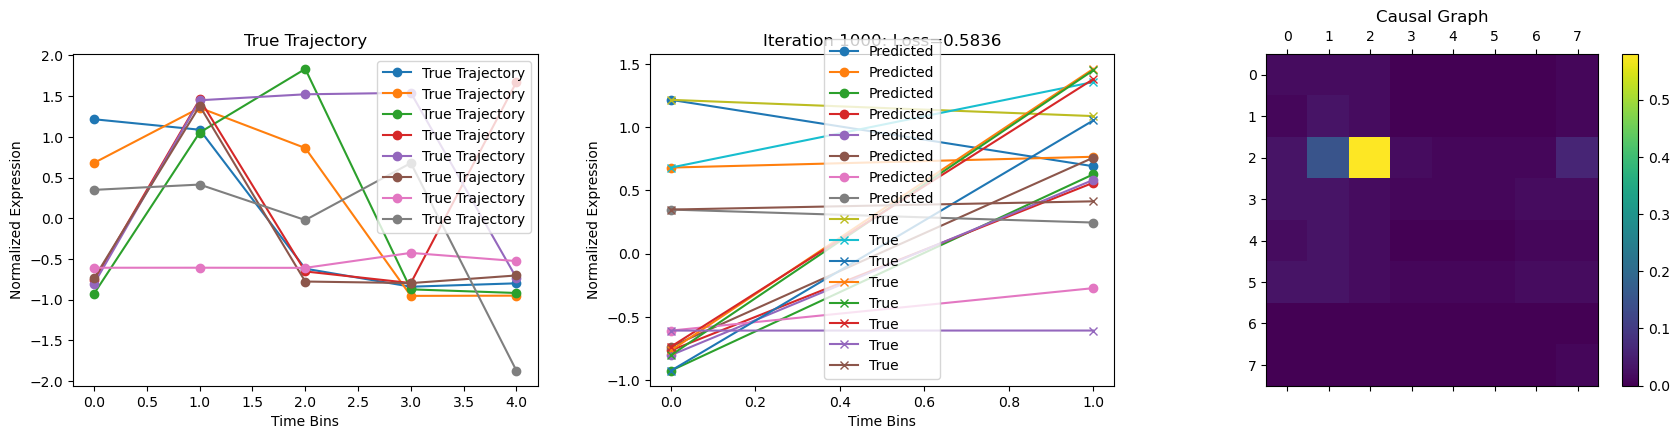

 20%|█▉        | 1999/10000 [02:51<26:29,  5.03it/s]

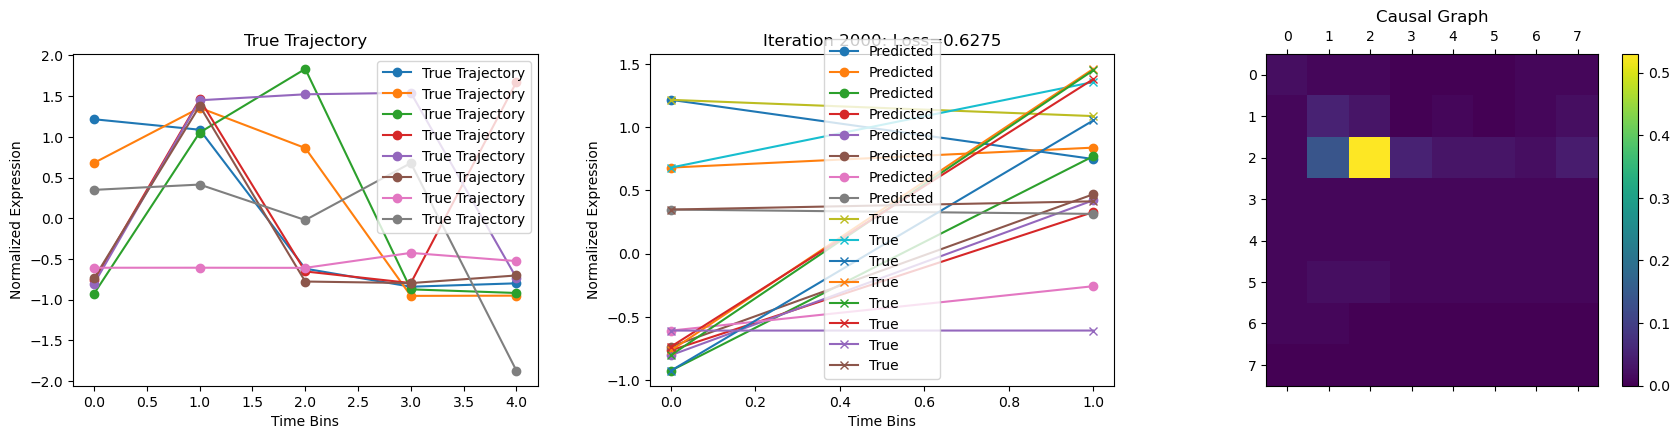

 30%|██▉       | 2999/10000 [08:54<54:22,  2.15it/s]  

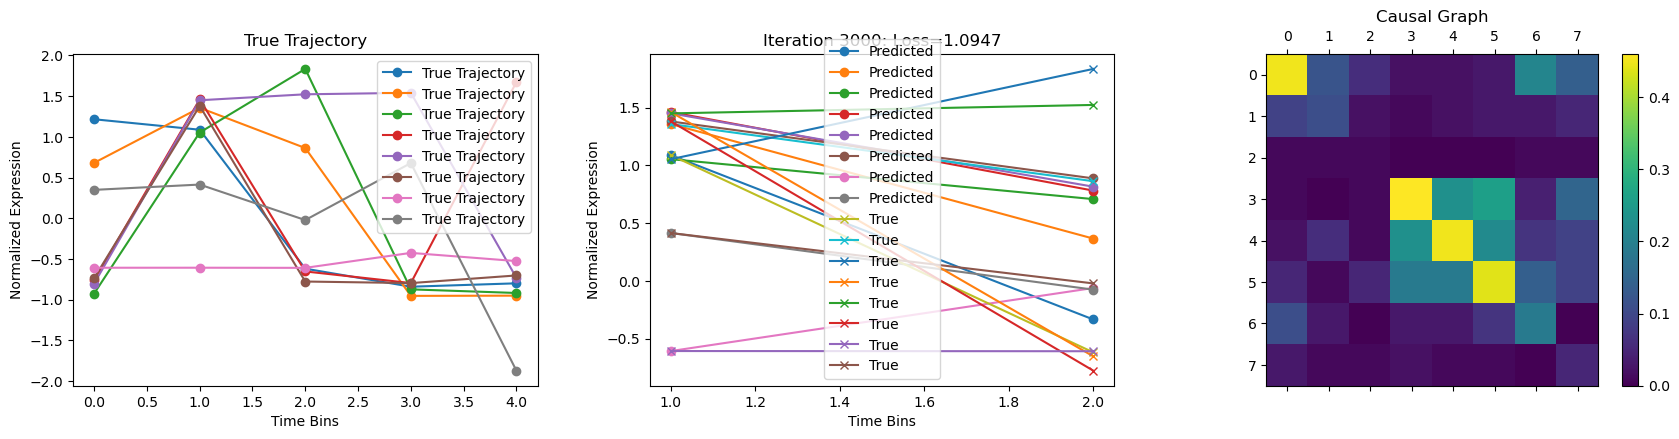

 40%|███▉      | 3999/10000 [16:26<44:00,  2.27it/s]  

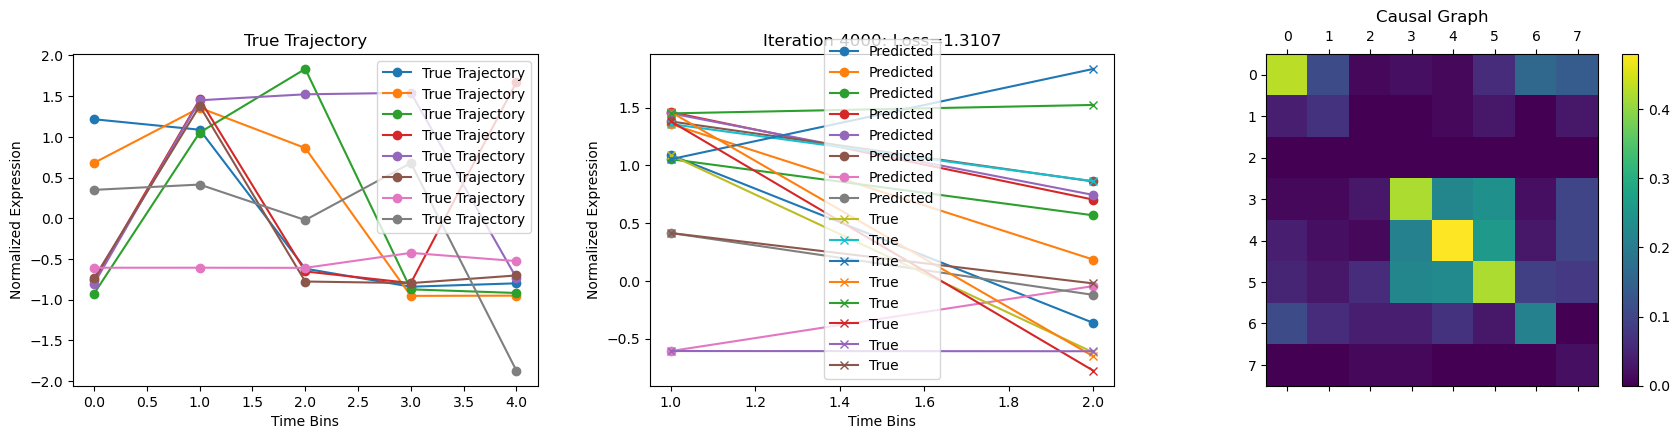

 50%|████▉     | 4999/10000 [24:30<41:45,  2.00it/s]  

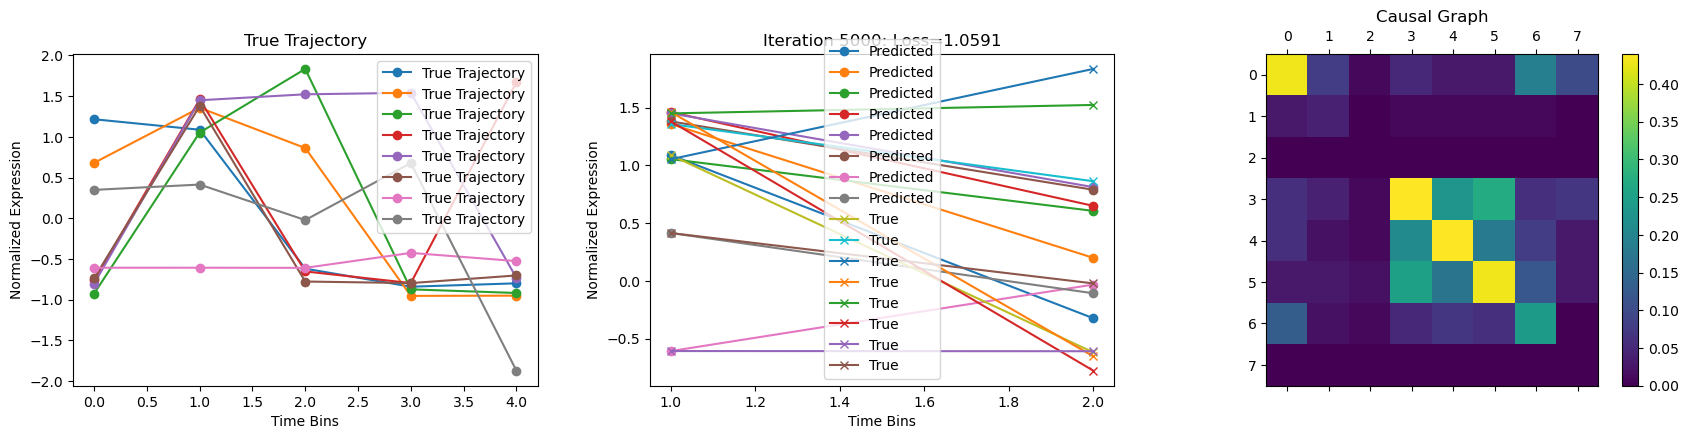

 60%|█████▉    | 5999/10000 [35:08<41:36,  1.60it/s]  

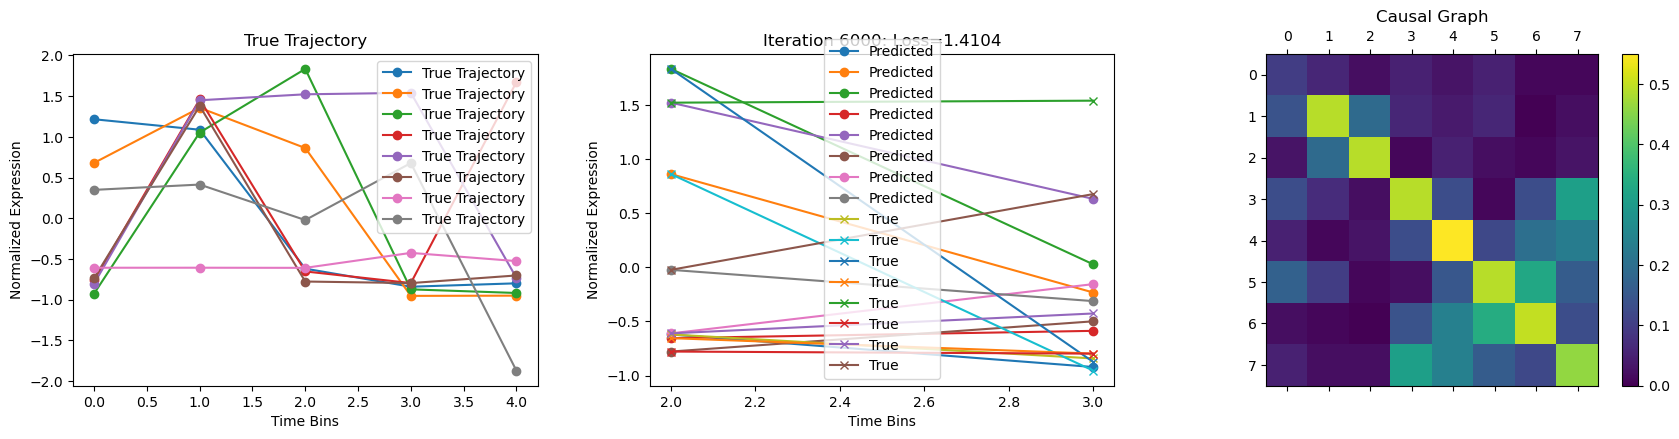

 70%|██████▉   | 6999/10000 [46:06<30:30,  1.64it/s]  

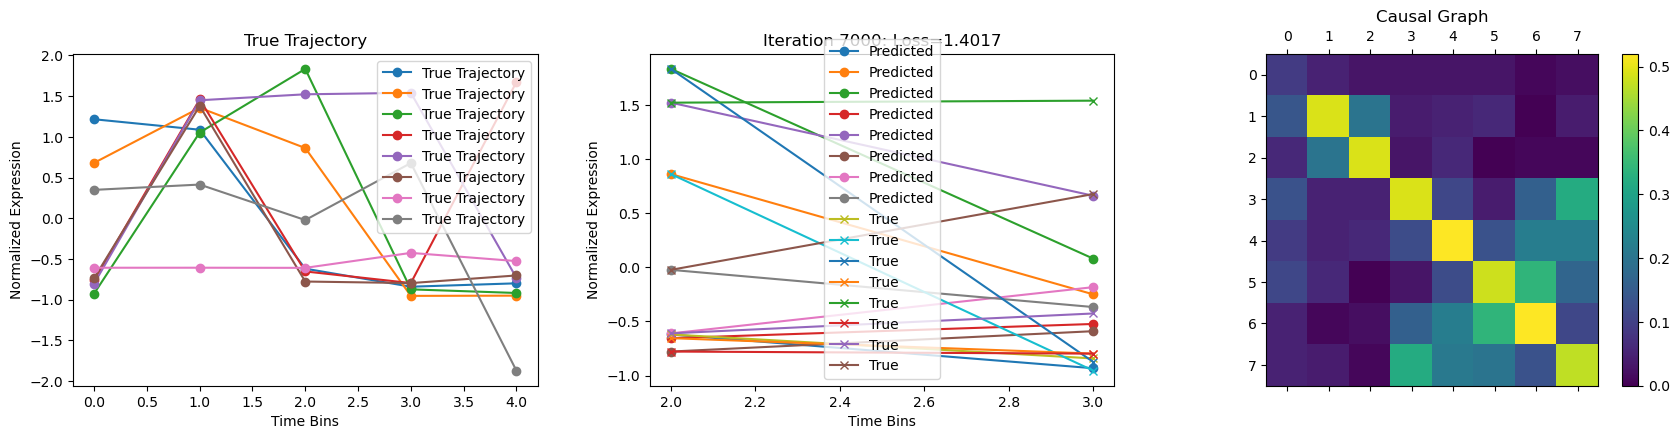

 80%|███████▉  | 7999/10000 [58:55<18:33,  1.80it/s]  

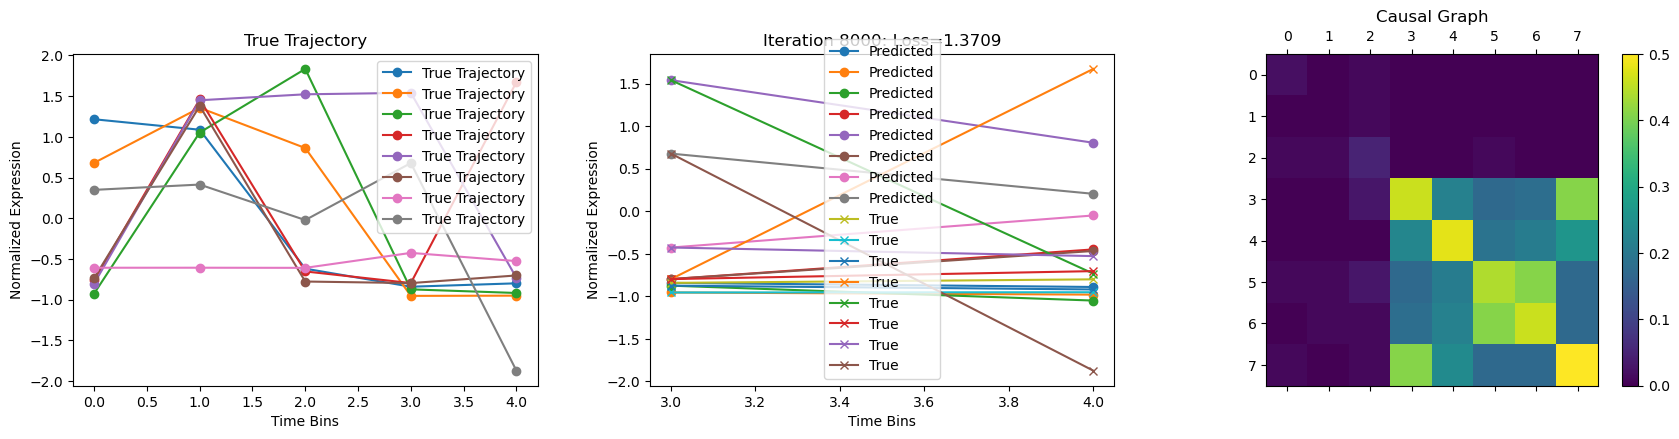

 90%|████████▉ | 8999/10000 [1:09:10<09:43,  1.71it/s]  

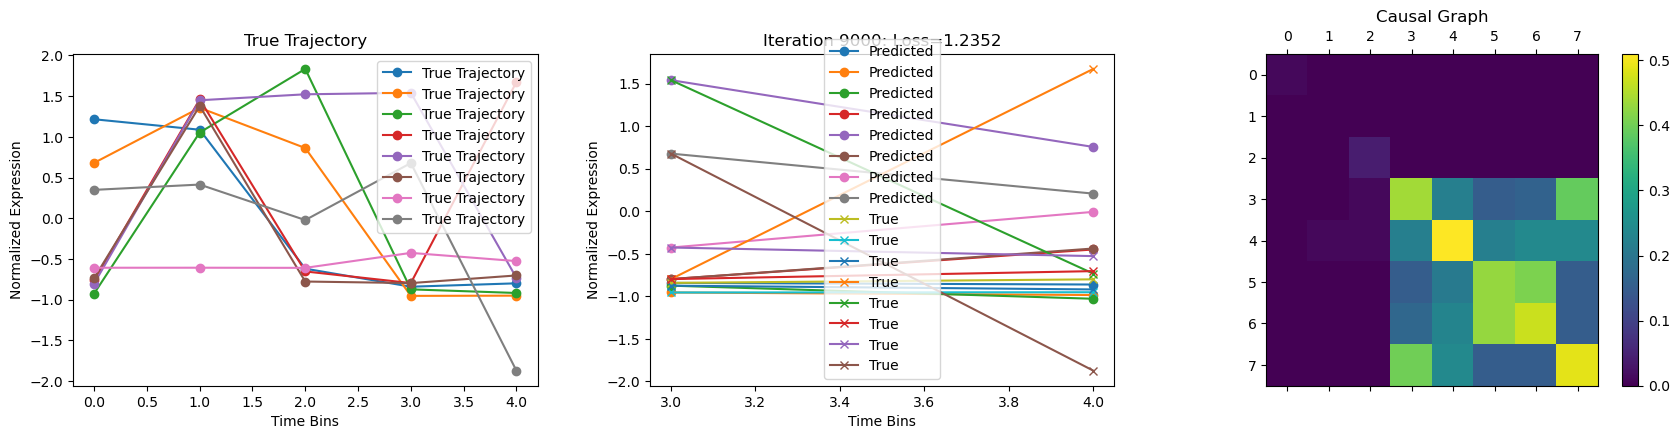

100%|█████████▉| 9999/10000 [1:18:33<00:00,  1.76it/s]

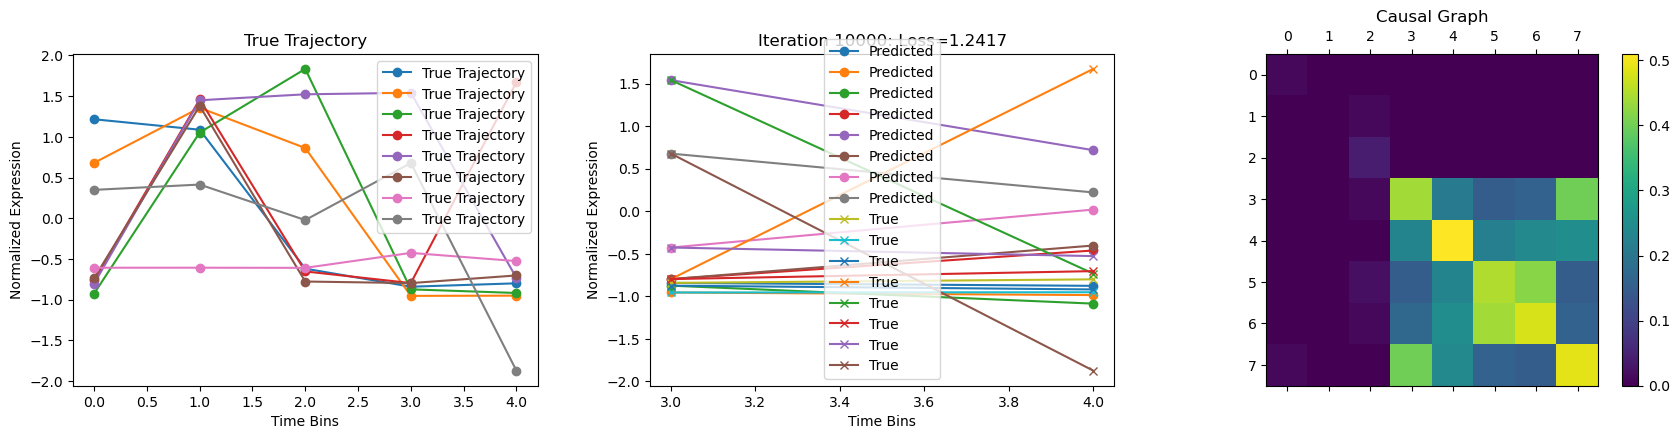

100%|██████████| 10000/10000 [1:18:35<00:00,  2.12it/s]


In [35]:
importlib.reload(models)
num_variables = 8
hidden_dim = 500
dims = [num_variables, hidden_dim, 1]  # Example: [8, 500, 1]
func = models.MLPODEF(dims=dims, GL_reg=0.05)

# Prepare your data tensor
# Assuming you have loaded your data into 'adata' as a single AnnData object
grouped_data = prepare_time_binned_data(adatas[0], time_column='t')
normalized_data, scaler = normalize_data(grouped_data)

# Train the model
train_sequential_discrete_time_ode(
    func=func,
    normalized_data=normalized_data,
    n_steps_per_transition=2500,  # Total steps = 2500 * 4 = 10000
    plot_freq=1000,
    l1_reg=0.0,
    l2_reg=0.05,
    plot=True,
    device="cuda" if torch.cuda.is_available() else "cpu"
)

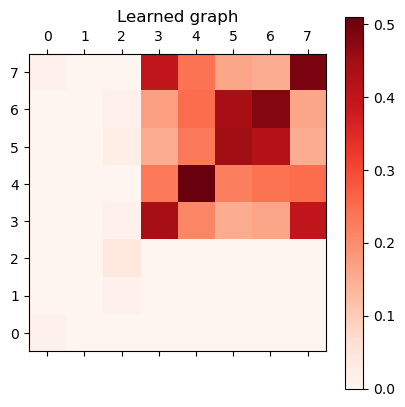

In [38]:
graph = func.causal_graph(w_threshold=0.0)
plt.matshow(graph, cmap="Reds")
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Learned graph")
plt.show()

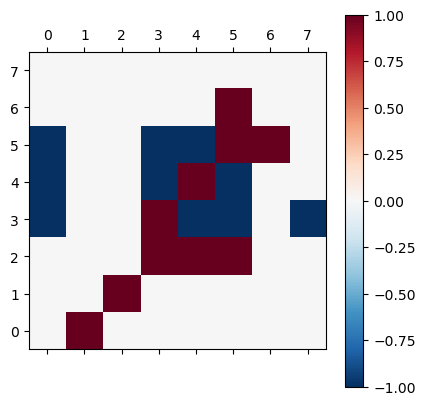

In [39]:
plt.matshow(data_loader.true_matrix, cmap="RdBu_r")
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

Text(0.5, 1.0, 'Learned Graph')

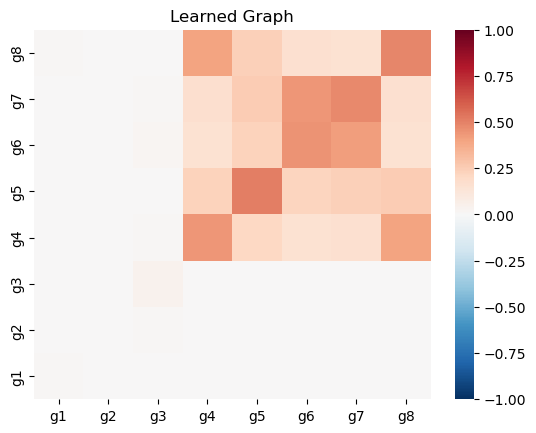

In [41]:
import seaborn as sns
gene_names = adatas[0].var_names

df_learned = pd.DataFrame(graph, index=gene_names, columns=gene_names)
sns.heatmap(df_learned, vmin=-1.0, vmax=1.0, cmap="RdBu_r")
plt.gca().invert_yaxis()
plt.title("Learned Graph")

Text(0.5, 1.0, 'Learned Graph')

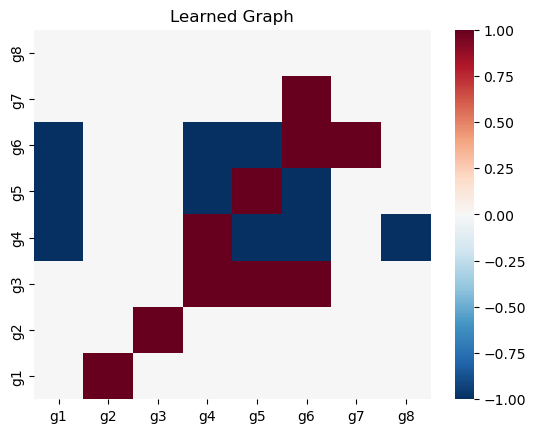

In [42]:
df_learned = pd.DataFrame(data_loader.true_matrix, index=gene_names, columns=gene_names)
sns.heatmap(df_learned, vmin=-1.0, vmax=1.0, cmap="RdBu_r")
plt.gca().invert_yaxis()
plt.title("Learned Graph")

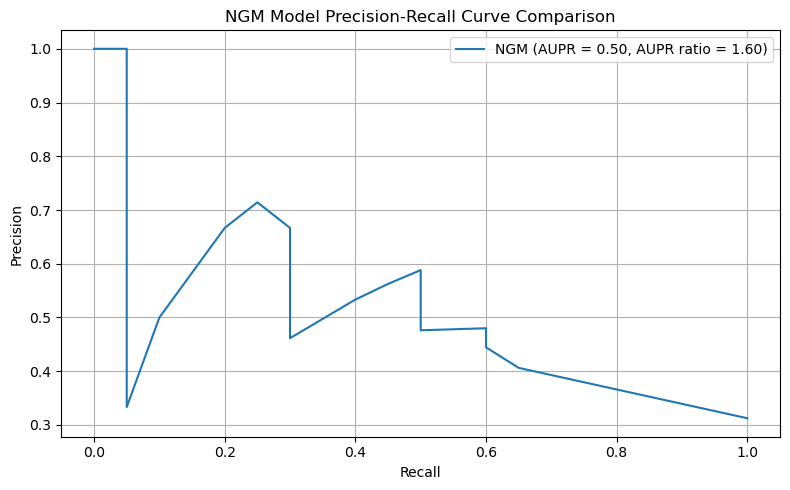

In [49]:
from sklearn.metrics import precision_recall_curve, average_precision_score
def compare_models(learned_graph, true_matrix):
        """Compare the performance of NGM model with and without knockouts"""
        plt.figure(figsize=(8, 5))

        y_true = np.abs(np.sign(true_matrix).astype(int).flatten())

        models = [
            ("NGM", learned_graph)
        ]

        for name, predictions in models:
            prec, rec, _ = precision_recall_curve(y_true, np.abs(predictions.flatten()))
            avg_prec = average_precision_score(y_true, np.abs(predictions.flatten()))
            plt.plot(
                rec,
                prec,
                label=f"{name} (AUPR = {avg_prec:.2f}, "
                f"AUPR ratio = {avg_prec / y_true.mean():.2f})",
            )

        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("NGM Model Precision-Recall Curve Comparison")
        plt.legend(loc="best")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
compare_models(graph, true_matrix)
